In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [7]:
os.listdir('.')
# os.chdir('drive/My Drive/Colab_Test/Dataset/Time-Series Prediction')

['sales.csv', 'birth.csv', 'daily-min-temperatures.csv', 'shampoo.csv']

In [8]:
def parser(x):
  return datetime.strptime(x, '%Y-%m-%d')

In [9]:
dataset = pd.read_csv('birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

In [11]:
test_parser = parser('1959-01-01')
test_parser
# Parser sudah berjalan dengan baik

datetime.datetime(1959, 1, 1, 0, 0)

In [12]:
dataset.describe()

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: Births, dtype: float64

In [13]:
dataset.isnull().sum()

# Data aman dan langsung dapat dilakukan pengujian tanpa harus cleaning

0

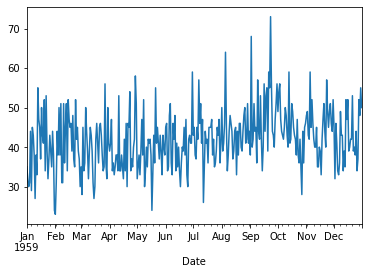

In [14]:
dataset.plot()

#Dari grafik diatas, dapat disimpulkan pada data ini tidak terdapat Trend dan tidak terdapat Seasonalitty

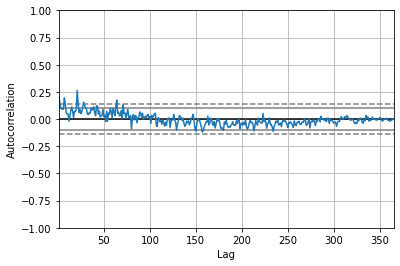

In [15]:
pd.plotting.autocorrelation_plot(dataset)


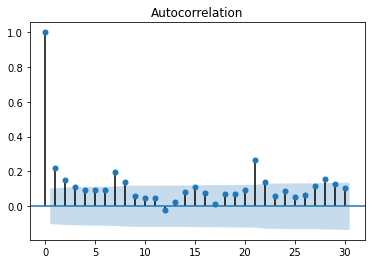

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(dataset, lags=30, ax=plt.gca())
plt.show()

Terdapat korelasi positif di lag 20, maka kita akan coba dengan variabel p adalah 5


In [17]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# ARIMA (Auto Correlation Integrated Moving Average)

p, AR(Autocorrelation) = 20
d, I (Integrated) = 2
q, MA (Moving Average) = 0

In [18]:
model = ARIMA(dataset, order=(7,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Births   No. Observations:                  364
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1221.912
Method:                       css-mle   S.D. of innovations              6.896
Date:                Thu, 17 Sep 2020   AIC                           2463.824
Time:                        11:16:32   BIC                           2502.796
Sample:                    01-02-1959   HQIC                          2479.313
                         - 12-31-1959                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0197      0.006      3.568      0.000       0.009       0.030
ar.L1.D.Births     0.1437      0.052      2.764      0.006       0.042       0.246
ar.L2.D.Births     0.0631      0.053

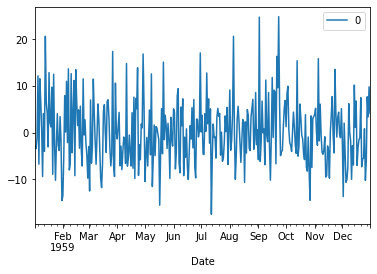

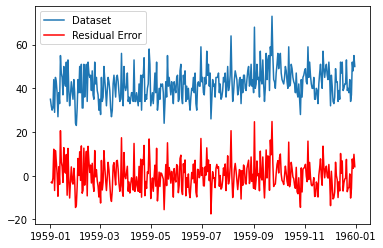

In [19]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [20]:
residuals

,0
Date,
1959-01-02,-3.019674
1959-01-03,-3.412665
1959-01-04,-1.077499
1959-01-05,12.132347
1959-01-06,-6.763678
...,...
1959-12-27,-5.936371
1959-12-28,7.652670
1959-12-29,3.355071


In [21]:
residuals.describe()

,0
count,364.000000
mean,0.088328
std,6.954210
min,-17.496497
25%,-4.594069
50%,-0.910722
75%,4.268877
max,24.808321


In [22]:
values = dataset.values
size = int(len(values) * 0.2)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for i in range(len(test)):
  model = ARIMA(history, order=(7,1,1))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  prediction = output[0]
  predictions.append(prediction)
  expected = test[i]
  history.append(expected)
  print('predicted=%f, expected=%f' % (prediction, expected))
error = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=39.211205, expected=27.000000
predicted=34.907871, expected=30.000000
predicted=33.380863, expected=42.000000
predicted=38.279486, expected=46.000000
predicted=41.715860, expected=41.000000
predicted=39.596939, expected=36.000000
predicted=35.242864, expected=45.000000
predicted=36.053968, expected=46.000000
predicted=39.888906, expected=43.000000
predicted=41.922589, expected=38.000000
predicted=41.467045, expected=34.000000
predicted=40.481464, expected=35.000000
predicted=39.153189, expected=56.000000
predicted=43.462600, expected=36.000000
predicted=43.411591, expected=32.000000
predicted=39.275897, expected=50.000000
predicted=40.063322, expected=41.000000
predicted=42.659591, expected=39.000000
predicted=40.709070, expected=41.000000
predicted=38.801656, expected=47.000000
predicted=44.689344, expected=34.000000
predicted=40.765223, expected=36.000000
predicted=39.832038, expected=33.000000
predicted=39.310378, expected=35.000000
predicted=39.071664, expected=38.000000


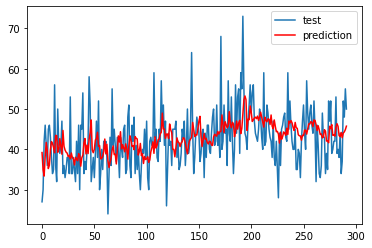

In [23]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test', 'prediction'])
plt.show()

In [14]:
def evaluate_arima_model(dataset_values, arima_order, test_size):
	# prepare training dataset
	train_size = int(len(dataset_values) * (1-test_size))
	train, test = dataset_values[0:train_size], dataset_values[train_size:]
	test_ori = test.copy()
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		prediction = model_fit.forecast()[0]
		predictions.append(prediction)
		history.append(test[t])
	# calculate out of sample error
	rmse = mean_squared_error(test, predictions, squared=False)
	return {'rmse': rmse, 'predictions': predictions, 'test': test_ori}

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_list, d_list, q_list, test_size):
	dataset = dataset.astype('float32')
	dataset_value = dataset
	train_size = int(len(dataset_value) * (1-test_size))
	test_set = dataset_value[train_size:]
	best_score, best_cfg = float("inf"), None
	for p in p_list:
		for d in d_list:
			for q in q_list:
				order = (p,d,q)
				try:
					result = evaluate_arima_model(dataset_value, order, test_size)
					if result['rmse'] < best_score:
						best_score, best_cfg = result['rmse'], order
						# best_pred = result['predictions']
					print('ARIMA%s RMSE=%.3f' % (order,result['rmse']))
				except:
					print('ARIMA(%s, %s, %s) not working' % (p,d,q))
					continue
	if best_cfg == None:
		print("Sad")
	else:
		print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
		best_pred = evaluate_arima_model(dataset_value, best_cfg, test_size)['predictions']
		plt.plot(test_set)
		plt.plot(best_pred, color='red')
		plt.legend(['test','prediction'])
		plt.show()

In [ ]:
import warnings

p_values = range(0, 30)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values, 0.2)

ARIMA(0, 0, 0) RMSE=6.539
ARIMA(0, 0, 1) RMSE=6.328
ARIMA(0, 0, 2) RMSE=6.276
ARIMA(0, 1, 0) RMSE=7.710
ARIMA(0, 1, 1) RMSE=6.942
ARIMA(0, 1, 2) RMSE=6.775
ARIMA(0, 2, 0) RMSE=13.049
ARIMA(0, 2, 1) RMSE=7.736
ARIMA(0, 2, 2) not working
ARIMA(1, 0, 0) RMSE=6.275
ARIMA(1, 0, 1) RMSE=6.733
ARIMA(1, 0, 2) not working
ARIMA(1, 1, 0) RMSE=6.947
ARIMA(1, 1, 1) RMSE=6.757
ARIMA(1, 1, 2) RMSE=6.833
ARIMA(1, 2, 0) RMSE=10.052
ARIMA(1, 2, 1) not working
ARIMA(1, 2, 2) not working
ARIMA(2, 0, 0) RMSE=6.235
ARIMA(2, 0, 1) RMSE=6.547
ARIMA(2, 0, 2) RMSE=6.608
ARIMA(2, 1, 0) RMSE=6.693
ARIMA(2, 1, 1) RMSE=6.729
ARIMA(2, 1, 2) RMSE=6.762
ARIMA(2, 2, 0) RMSE=8.846
ARIMA(2, 2, 1) not working
ARIMA(2, 2, 2) not working
ARIMA(3, 0, 0) RMSE=6.227
ARIMA(3, 0, 1) RMSE=6.520
ARIMA(3, 0, 2) RMSE=6.522
ARIMA(3, 1, 0) RMSE=6.604
ARIMA(3, 1, 1) RMSE=6.749
ARIMA(3, 1, 2) RMSE=6.787
ARIMA(3, 2, 0) RMSE=8.060
ARIMA(3, 2, 1) not working
ARIMA(3, 2, 2) not working
ARIMA(4, 0, 0) RMSE=6.235
ARIMA(4, 0, 1) RMSE=6.466
AR

# SARIMA(Seasonal Autoregressive Integrated Moving Average)


In [1]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [7]
	d_params = [0, 1]
	q_params = [0, 1]
	t_params = ['n','c','t','ct']
	P_params = [7]
	D_params = [0, 1]
	Q_params = [0, 1]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [12]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset.values, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

done
